### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/randomforest_analysis">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Mount with google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/dirve')

**`treeinterpreter` . PyPi**

Package for interpreting scikit-learn’s decision tree [Reference](https://pypi.org/project/treeinterpreter/)

In [1]:
!pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti

**`factor-analyzer` · PyPI**

Package to perform exploratory and factor analysis (EFA), with several optional rotations. [Reference](https://pypi.org/project/factor-analyzer/)

In [ ]:
!pip install factor_analyzer
from factor_analyzer import *

Import other packages required from **`github.com`**. All `*.py` will be stored under the following location i.e. `'/content/model_validation'`.

In [ ]:
!git clone 'http://github.com/Nak007/model_validation.git'
!git clone 'http://github.com/Nak007/randomforest_analysis.git'
!git clone 'http://github.com/Nak007/varclus.git'

Other packages.

In [3]:
import pandas as pd, numpy as np, os, pickle, sys
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import (roc_auc_score, 
                             accuracy_score,
                             f1_score, 
                             make_scorer)
from sklearn.model_selection import GridSearchCV
pd.options.display.float_format = '{:,.4f}'.format

sys.path.append('/content/model_validation')
sys.path.append('/content/randomforest_analysis')
sys.path.append('/content/varclus')
from model_validation import *
from randomforest_analysis import *
from varclus import *

### <font color="green" size=5> Make classification data </font>

Generate a random n-class classification problem. [Reference](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [5]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples     = 10000, 
                           n_features    = 50, 
                           n_informative = 15, 
                           n_redundant   = 20, 
                           random_state  = 0, 
                           shuffle       = True, 
                           n_classes     = 2, 
                           weights       = [0.7,0.3])

X = pd.DataFrame(X, columns=["feature_" + str(n).zfill(2) 
                              for n in range(1,X.shape[1]+1)]) 

### <font color="green" size=5> Variable Clustering </font>

In [6]:
vc = VariableClustering(maxclus=25, maxeigval2=0.8).fit(X)

In [9]:
vc.info.head(10)

,N_Vars,Eigval1,Eigval2,VarProp,min_RSO,max_RSN,max_RSr
Cluster,,,,,,,
1,4,2.3870,0.6713,0.5967,0.4618,0.3376,0.6869
2,4,2.5550,0.7732,0.6387,0.4753,0.3335,0.6779
3,6,3.2034,0.8930,0.5339,0.4528,0.3895,0.7216
4,3,1.8628,0.7256,0.6209,0.5077,0.2950,0.5819
5,2,1.5379,0.4621,0.7689,0.7689,0.3940,0.3813
6,3,1.9811,0.5976,0.6604,0.5778,0.3560,0.4683
7,2,1.6351,0.3649,0.8175,0.8175,0.2909,0.2573
8,3,1.7450,0.7212,0.5817,0.5048,0.2895,0.6970
9,2,1.6184,0.3816,0.8092,0.8092,0.2886,0.2682


In [11]:
vc.r2.head(10)

RS_Own  RS_NC  RS_Ratio
Cluster Variable                           
1       feature_35  0.7266 0.2345    0.3572
        feature_20  0.7132 0.3376    0.4330
        feature_14  0.4618 0.1660    0.6453
        feature_42  0.4854 0.2508    0.6869
2       feature_38  0.7311 0.1513    0.3168
        feature_15  0.7615 0.3335    0.3578
        feature_24  0.5870 0.2150    0.5261
        feature_31  0.4753 0.2260    0.6779
3       feature_04  0.7461 0.3895    0.4159
        feature_30  0.5229 0.1549    0.5646

We can use `pd.plotting.scatter_matrix` to visualize results from `VariableClustering` through a matrix of scatter plots.

== Group 8 ==


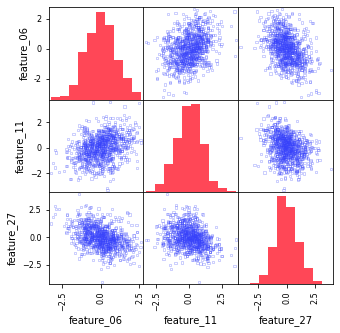

In [22]:
random_cluster = np.random.randint(1,len(vc.info))
index = vc.clus_corr.index.get_level_values(0)==random_cluster
X0 = X[vc.clus_corr.loc[index].index.get_level_values(1)]
X0, figsize = (X0 - X0.mean()) / X0.std(), ((1.7*X0.shape[1],)*2)

# Keyword arguments
print(f"== Group {random_cluster} ==")
kwargs = dict(alpha=0.25, ec='#3742fa', marker='s',
              figsize=figsize, facecolors='none', s=5, 
              hist_kwds=dict(color="#ff4757"))
pd.plotting.scatter_matrix(X0.sample(np.fmin(1000,len(X0))), **kwargs)
plt.show()

Let's select variable, with the lowest **RS_Ratio** from each **Cluster**.

In [23]:
vc_columns = vc.r2.reset_index().groupby('Cluster').first()["Variable"].values
X = X[vc_columns].copy()

In [24]:
X.head()

,feature_35,feature_38,feature_04,feature_16,feature_29,feature_50,feature_28,feature_06,feature_47,feature_34,...,feature_07,feature_17,feature_43,feature_08,feature_32,feature_46,feature_18,feature_10,feature_48,feature_33
0,-5.3025,-3.8473,-5.8209,5.3102,-1.5390,-3.5112,-2.8553,3.6661,1.3341,0.0864,...,-0.9490,-0.5209,-2.0801,1.6888,-0.7690,0.1004,1.5552,1.2424,-0.5062,1.0201
1,12.6742,1.9356,-3.3807,5.3643,2.1548,-0.4721,-4.2643,-0.6984,-1.6154,-1.5288,...,0.0086,1.6108,0.2536,0.1296,0.3723,1.6303,0.5297,0.9639,-0.1974,-2.9190
2,3.0645,-4.2059,1.5571,-10.6994,1.6208,-2.8808,-1.1452,-2.2951,-0.3335,-0.7244,...,4.0456,-0.3022,-0.5363,-0.8629,-0.3737,0.2845,0.1827,-0.9020,-1.3187,-1.4998
3,5.1430,1.1679,0.5895,6.3558,0.7231,-0.3071,-2.8606,-2.2330,-0.7059,-1.2294,...,1.6653,-0.5886,-0.4969,0.4456,0.6658,-0.6268,-0.4920,1.5127,-2.1439,-0.8806
4,0.5939,-0.7130,2.7138,2.5037,-3.7090,2.7843,-5.5655,-0.7743,1.6192,0.4517,...,0.7942,-0.1592,1.1481,-0.4756,0.6142,-0.6227,-0.3985,1.1340,-1.2819,-2.5491


### <font color="green" size=5> Split train and test sets </font>

Split data into **_train_**, and **_test_** sets given **_test_size_**

In [25]:
tts_kwargs = {"test_size"   : 0.3 , 
              "shuffle"     : True, 
              "random_state": 0}
X_train, X_test, y_train, y_test = tts(X, y, **tts_kwargs)

Determine _**class_weight**_ for imbalanced classes

In [26]:
def ClassWeights(labels):
    '''Determine `class_weight` for imbalanced classes'''
    cls, cnt = np.unique(labels, return_counts=True)
    return dict([(c,np.round(sum(cnt)/n,4)) for c,n in zip(cls,cnt)])

In [27]:
class_weight = ClassWeights(y_train)
class_weight

{0: 1.4219, 1: 3.3702}

Summary of **_train_** and **_test_** sets, and _**class_weight**_

In [28]:
def train_test(X_train, X_test, y_train, y_test):
    data = []
    for (nx,ny) in zip([X_train,X_test],[y_train,y_test]):
        weights = dict([(f'weight_{c}',w) for c,w in ClassWeights(ny).items()])
        labels  = dict([(f'class_{c}',(ny==c).sum()) for c in np.unique(ny)])
        data.append({**{'N':nx.shape[0]}, **weights, **labels})
    return pd.DataFrame(data, index=['Train','Test'])

In [29]:
train_test(X_train, X_test, y_train, y_test)

,N,class_0,class_1,weight_0,weight_1
Train,7000,4923,2077,1.4219,3.3702
Test,3000,2063,937,1.4542,3.2017


### <font color="green" size=5> Fitting classifier </font>

In [30]:
def EstimateDepth(*args):
    '''Private function to estimate max_depth 
    for tree-based model'''
    max_len = float(max([len(a) for a in args]))
    return int(np.ceil(np.log2(max_len)))

Estimate **`max_depth`** and specify initial parameters for random forest classifier.

In [31]:
max_depth = EstimateDepth(X_train, X_test)
model = rf(**{"random_state":  0, 
              "n_estimators": 50, 
              "n_jobs"      : -1, 
              "class_weight": class_weight,
              "max_features": "sqrt"})

Specify **`sklearn.metrics`** to evaluate the change of parameter(s).

In [35]:
scoring = {'F1-Score': make_scorer(f1_score), 
           'AUC'     : make_scorer(roc_auc_score),
           'Accuracy': make_scorer(accuracy_score)}

In [38]:
gs = GridSearchCV(model, 
                  param_grid={'max_depth': range(2, np.fmax(max_depth,15))},
                  scoring=scoring, 
                  refit=False, 
                  return_train_score=True, 
                  n_jobs=-1, cv=5).fit(X_train, y_train)

<font color='blue' size=4>**GridSearchCV result**</font>

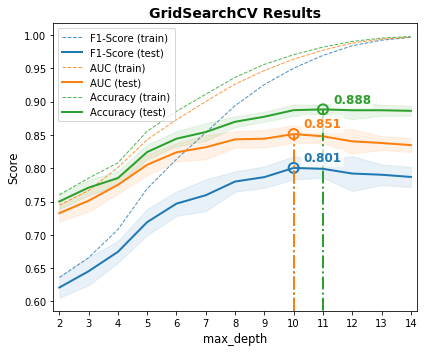

In [44]:
ax = PlotGridSearch(gs, decimal=3)
ax.legend(loc=2)

Select the appropriate number of **`max_depth`**.

In [45]:
init_kwargs = {"random_state": 0, 
               "n_estimators": 50, 
               "n_jobs"      : -1, 
               "class_weight": class_weight, 
               'max_depth'   : 10, 
               "max_features": "sqrt"}

In [46]:
clf = rf(**init_kwargs).fit(X_train, y_train)
y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba  = clf.predict_proba(X_test )[:,1]

Specify parameters for **`eval_classifier`** and build plotting function.

The method indices (parameter: **plots**) are as follows:
- 0 : Confusion matrix, **cfm_plot**
- 1 : F1-Score, **f1score_plot**
- 2 : Gini index, **gini_plot**
- 3 : Distribution of binary classes, **dist_plot**
- 4 : Kolmogorov–Smirnov test, **ks_plot**
- 5 : Gains, **gains_plot**
- 6 : Lift, **lift_plot**

In [51]:
def plotting_classifier(y_true, y_proba):
    # Parameters
    params = {'plots'  : [0, 2, 3, 6],
              'ax_dict': [# Confusion matrix
                          {'threshold':0.5, 'mat_dict':{'cmap':plt.cm.tab20}}, 
                          # Gini index
                          {'plot_dict':{'color':'blue', 'linestyle':'-'}}, 
                          # Distribution of binary classes
                          {'n_tick':10, 'bins':20, 'labels':['non-target','target'],
                           'bar_dict':{'width':0.8}}, 
                          # Lift chart
                          {'plot':'rate', 'bound':[0,100], 'step':10}]}
    fig, axes = Axes2grid(4, 2, figsize=(5, 3.5))
    eval_classifier(y_true, y_proba, **{**params,**{'axes':axes}})
    fig.tight_layout()
    plt.show()

Observe performace of **X_train** after retraining classifier.

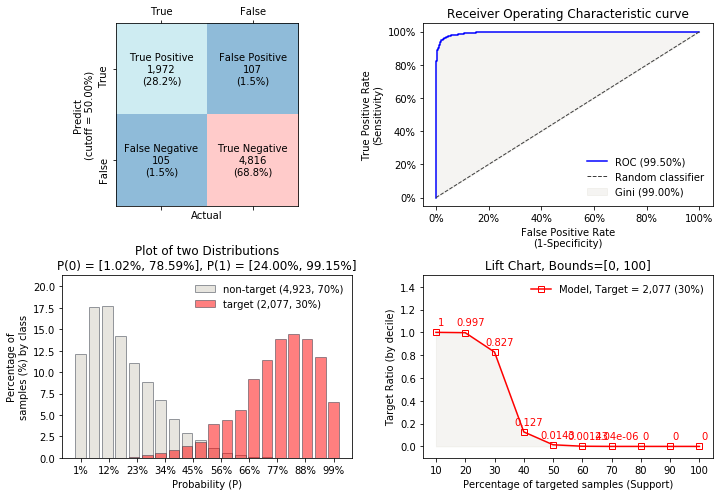

In [52]:
plotting_classifier(y_train, y_train_proba)

Validate performace of model with unseen data, **X_test**.

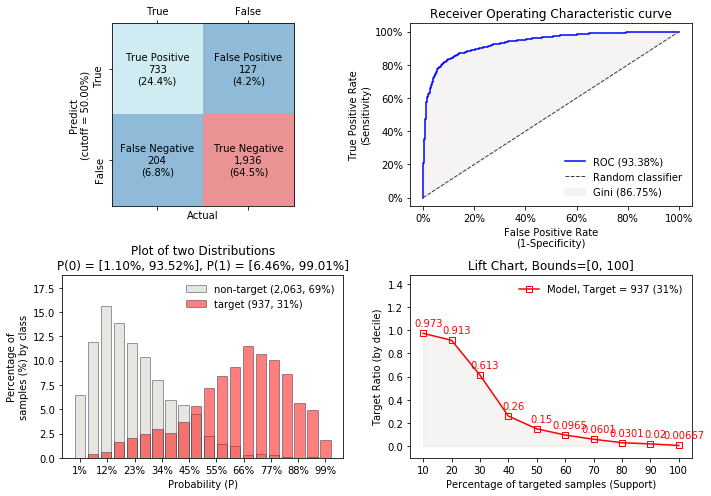

In [53]:
plotting_classifier(y_test, y_test_proba)

**Importance Values**
- sklearn (average decrease in impurity or Information Gain)
- Directional Feature Contributions (DFC)
- Permute variable (Permutation Importance)
- Drop variable (Drop-Column Importance)

In [55]:
model = FeatureImportance().fit(clf, X_train, y_train)

In [56]:
model.info.head(10)

,gain_score,dfc_score,permute_score,drop_score,mean_score
features,,,,,
feature_35,0.1174,0.1360,0.1820,0.0555,0.1227
feature_47,0.0755,0.0990,0.1173,0.0944,0.0965
feature_50,0.1075,0.1275,0.1104,0.0123,0.0894
feature_44,0.0889,0.0966,0.1018,0.0465,0.0834
feature_22,0.0699,0.0598,0.0507,0.0482,0.0571
feature_16,0.0495,0.0492,0.0683,0.0557,0.0557
feature_29,0.0625,0.0525,0.0575,0.0462,0.0547
feature_28,0.0589,0.0631,0.0524,0.0396,0.0535
feature_04,0.0622,0.0662,0.0456,0.0366,0.0527


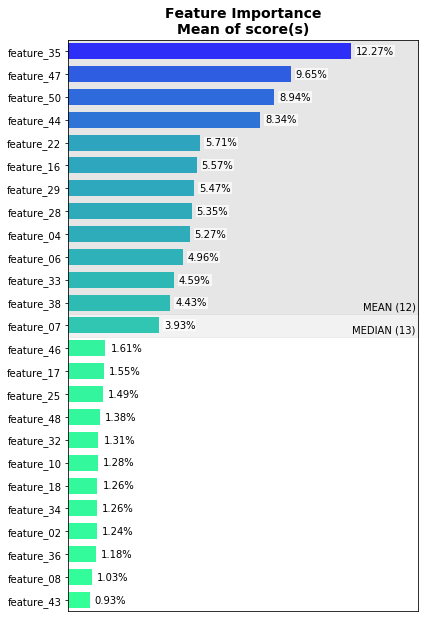

In [66]:
model.plotting("mean_score", sort_by="mean_score")

Select feature(s), whose importance is equal to or greater than defined cutoff.

In [71]:
final_features = [c for c in list(X) if c in model.info.index[:13]]
final_features

['feature_35',
 'feature_38',
 'feature_04',
 'feature_16',
 'feature_29',
 'feature_50',
 'feature_28',
 'feature_06',
 'feature_47',
 'feature_44',
 'feature_22',
 'feature_07',
 'feature_33']

### <font color="green" size=5> Retrain classifier </font>

Retrain model with new set of variables and validate fitted model accordingly.

In [72]:
clf.fit(X_train[final_features], y_train)
y_train_proba_1 = clf.predict_proba(X_train[final_features])[:,1]
y_test_proba_1  = clf.predict_proba(X_test[final_features] )[:,1]

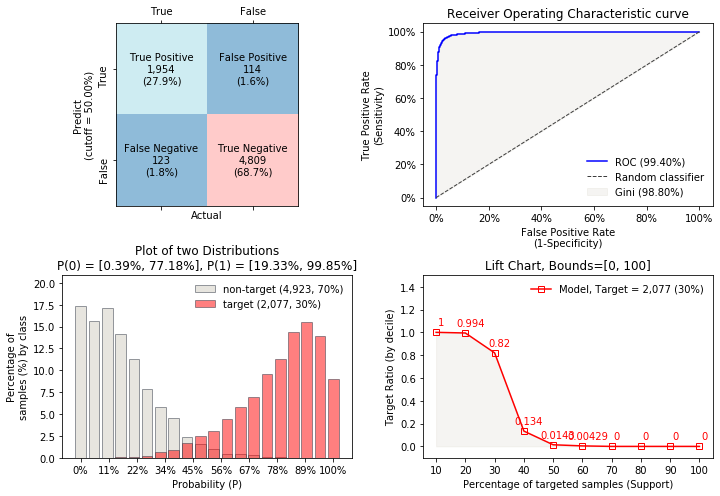

In [73]:
plotting_classifier(y_train, y_train_proba_1)

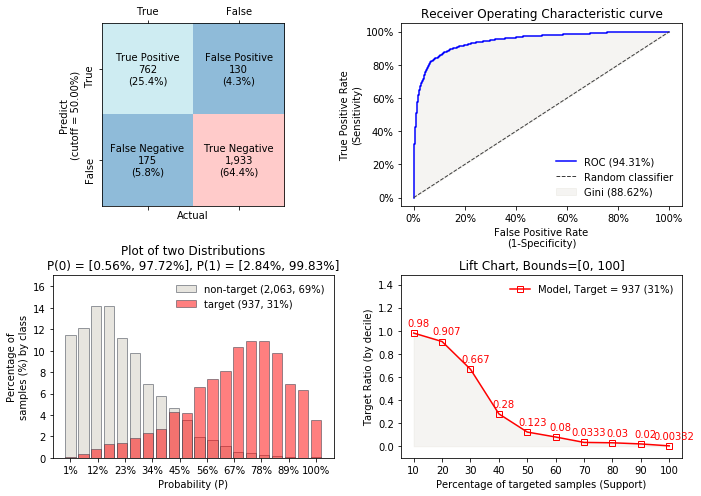

In [74]:
plotting_classifier(y_test, y_test_proba_1)

We will use **`TreeInterpreter`** to observe the relationship between feature contributions and variables. This type of visualization will facilitate an understanding of which features are important for the classification. Use **`Axes2grid`** to help creating multiple axes at specific location inside a regular grid.

In [75]:
model = TreeInterpreter(clf, y_train, X_train[final_features])

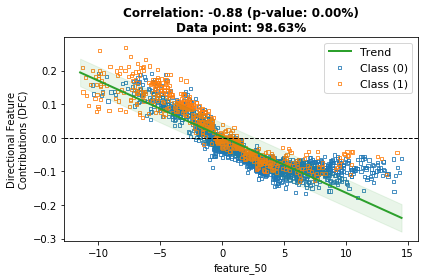

In [99]:
np.random.seed(None)
var = np.random.choice(final_features)
model.plotting(var, tight_layout=True, frac=0.3)

Directional feature contribution can be seen as an average incremental increase/decrease probability from bias.

### <font color="green" size=5> Find random_state </font>

Use **`tts_randomstate`** to determine the best `random_state` in splitting data that optimizes objective function e.g. Flase Negative or Gini Coefficient.

In [100]:
np.random.seed(0)
random_states = np.random.randint(1000, size=30)
random_states

array([684, 559, 629, 192, 835, 763, 707, 359,   9, 723, 277, 754, 804,
       599,  70, 472, 600, 396, 314, 705, 486, 551,  87, 174, 600, 849,
       677, 537, 845,  72])

In [101]:
model = tts_randomstate(clf, X[final_features], y, tts_kwds={"test_size":0.3, "shuffle":True})
model.fit(random_states)

In [102]:
model.info.head()

tp   fp   fn    tn  f1_score  roc_auc_score  \
random_state train                                                  
684          False   731  136  168  1965    0.8279         0.9484   
             True   1970  137  145  4748    0.9332         0.9937   
559          False   703  140  187  1970    0.8113         0.9419   
             True   1990  144  134  4732    0.9347         0.9938   
629          False   698  143  193  1966    0.8060         0.9407   

                    accuracy_score  
random_state train                  
684          False          0.8987  
             True           0.9597  
559          False          0.8910  
             True           0.9603  
629          False          0.8880

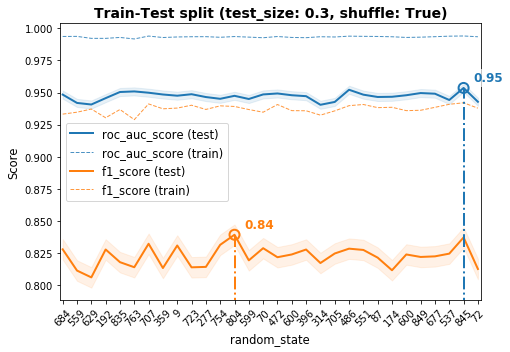

In [106]:
model.plotting(["roc_auc_score", "f1_score"], criterion="max", decimal=2)

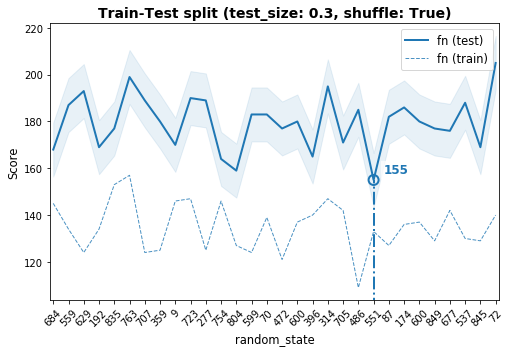

In [108]:
model.plotting(["fn"], decimal=0, criterion="min")

### <font color="green" size=5> Final classifier </font>

Split data into **_train_**, and **_test_** sets

In [109]:
tts_kwds = {"test_size"   : 0.3,
            "random_state": 845, 
            "shuffle"     : True}
X_train, X_test, y_train, y_test = tts(X[final_features], y, **tts_kwds)

In [110]:
class_weight = ClassWeights(y_train)
class_weight

{0: 1.4368, 1: 3.2895}

Summary of **_train_** and **_test_** sets, and _**class_weight**_

In [111]:
train_test(X_train, X_test, y_train, y_test)

,N,class_0,class_1,weight_0,weight_1
Train,7000,4872,2128,1.4368,3.2895
Test,3000,2114,886,1.4191,3.3860


In [112]:
clf = rf(**{"random_state": 0, 
            "n_estimators": 50, 
            "n_jobs"      : -1, 
            "class_weight": class_weight, 
            "max_depth"   : 10, 
            "max_features": "sqrt"})

In [113]:
clf.fit(X_train, y_train)
y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba  = clf.predict_proba(X_test )[:,1]

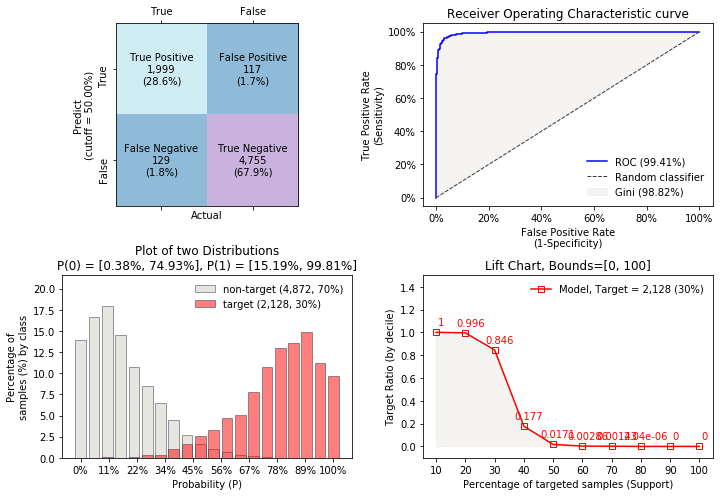

In [114]:
plotting_classifier(y_train, y_train_proba)

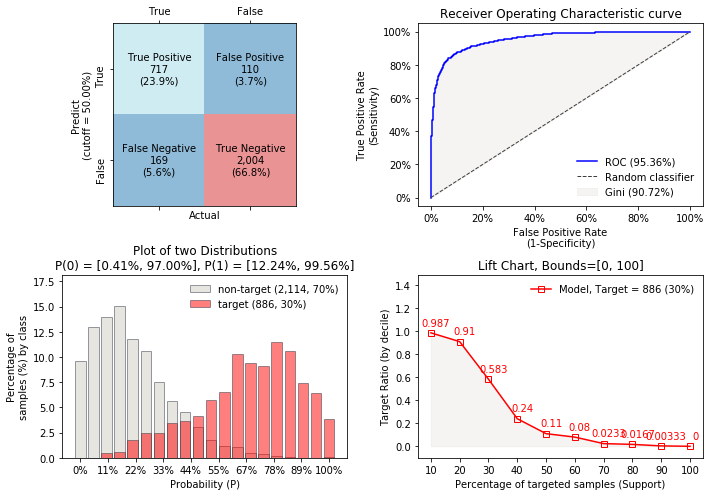

In [115]:
plotting_classifier(y_test, y_test_proba)

In [116]:
fi_model = FeatureImportance().fit(clf, X_train, y_train)

In [117]:
fi_model.info

,gain_score,dfc_score,permute_score,drop_score,mean_score
features,,,,,
feature_35,0.1367,0.1587,0.2121,0.1345,0.1605
feature_47,0.0754,0.0936,0.1144,0.1381,0.1054
feature_50,0.1138,0.1374,0.1170,0.0337,0.1005
feature_22,0.0944,0.0815,0.0814,0.1125,0.0925
feature_44,0.0930,0.1037,0.1001,0.0552,0.0880
feature_29,0.0708,0.0598,0.0632,0.0892,0.0707
feature_16,0.0630,0.0534,0.0622,0.0805,0.0648
feature_38,0.0594,0.0530,0.0502,0.0751,0.0594
feature_33,0.0567,0.0445,0.0384,0.0916,0.0578


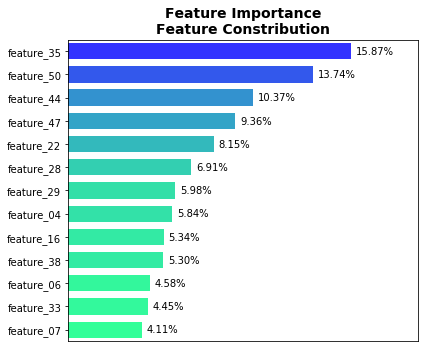

In [118]:
fi_model.plotting("dfc_score")

In [119]:
ti_model = TreeInterpreter(clf, y_train, X_train)

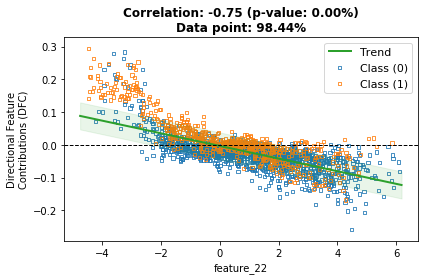

In [120]:
np.random.seed(None)
var = np.random.choice(X_train.columns)
ti_model.plotting(var, tight_layout=True, frac=0.3)

Save classifer.

In [ ]:
pickle.dump(clf, open('final_model.sav','wb'))

### <font color="green" size=5> Calibration of probability </font>

The purpose of calibration is to improve estimated probabilities. This method requires grouping and validation of bin-edges producing a monotonically increasing target rate before carrying out linear-calibration.

In [121]:
estimates = np.round(clf.predict_proba(X[final_features])[:,1], 4)

In [140]:
calibr = Calibrate_Proba(bins=np.arange(2,21), equal_width=True).fit(y, estimates)

Use **`plotting_error()`** to observe how change in number of bins and calibration can affect Mean Squared Error (MSE).

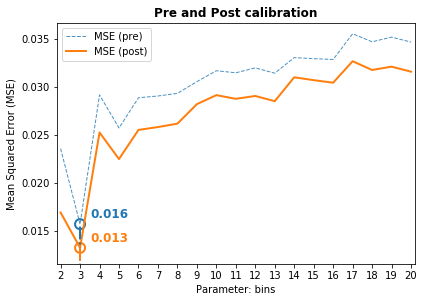

In [141]:
ax = calibr.plotting_error(decimal=3)

Use **`plotting_calib()`** to see the result of $n$-bin calibration.

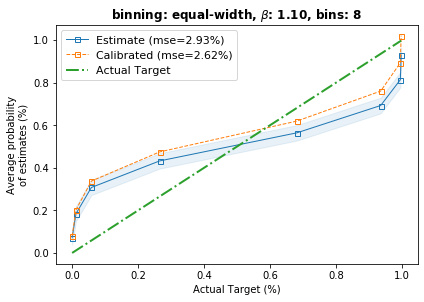

In [145]:
bin_num = 8
ax = calibr.plotting_calib(bin_num)

Use **`plotting_hist()`** to enable us to compare calibrated estimates and actual values.

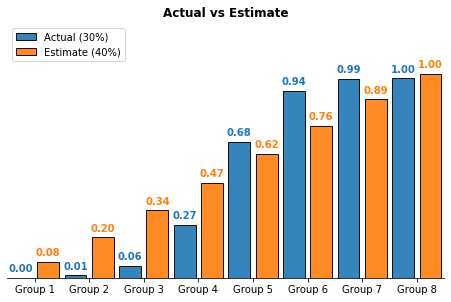

In [149]:
ax = calibr.plotting_hist(bin_num, decimal=2)

Summary table

In [147]:
pd.DataFrame(calibr.result[bin_num].info)

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets,calib_proba
0,0.0038,0.1281,0.2557,0.0038,0.1280,0.0716,0.0331,0.0004,0.0786
1,0.1281,0.2524,0.2415,0.1281,0.2523,0.1844,0.0356,0.0120,0.2025
2,0.2524,0.3767,0.1379,0.2525,0.3766,0.3078,0.0356,0.0587,0.3378
3,0.3767,0.5010,0.0708,0.3767,0.5007,0.4324,0.0360,0.2655,0.4747
4,0.5010,0.6252,0.0540,0.5013,0.6252,0.5644,0.0363,0.6815,0.6196
5,0.6252,0.7495,0.0725,0.6258,0.7495,0.6926,0.0368,0.9352,0.7603
6,0.7495,0.8738,0.0957,0.7498,0.8737,0.8137,0.0358,0.9948,0.8932
7,0.8738,0.9981,0.0719,0.8741,0.9981,0.9297,0.0353,0.9972,1.0205


Assign probabilities into groups with respect to `bin_edges`.

In [150]:
bin_edges = calibr.result[bin_num].bin_edges
group_proba = np.digitize(estimates, calibr.result[bin_num].bin_edges)
beta = calibr.result[bin_num].beta
print("Beta: {:,.4f}".format(beta))

Beta: 1.0978


### <font color="green" size=5> Score </font>

Use **`cal_score()`** to convert probability into score.

In [151]:
p = min(estimates)
score_kwds = dict(pdo=20, point=0, odd=p/(1-p), 
                  min_prob=min(estimates),
                  max_prob=max(estimates))

In [152]:
final_group = pd.DataFrame(calibr.result[bin_num].info)
final_group["min_score"] = cal_score(final_group["r_min"], **score_kwds).astype(int)
final_group["max_score"] = cal_score(final_group["r_max"], **score_kwds).astype(int)
scores = cal_score(estimates, **score_kwds).astype(int)

In [153]:
final_group

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets,calib_proba,min_score,max_score
0,0.0038,0.1281,0.2557,0.0038,0.1280,0.0716,0.0331,0.0004,0.0786,0,105
1,0.1281,0.2524,0.2415,0.1281,0.2523,0.1844,0.0356,0.0120,0.2025,105,129
2,0.2524,0.3767,0.1379,0.2525,0.3766,0.3078,0.0356,0.0587,0.3378,129,146
3,0.3767,0.5010,0.0708,0.3767,0.5007,0.4324,0.0360,0.2655,0.4747,146,161
4,0.5010,0.6252,0.0540,0.5013,0.6252,0.5644,0.0363,0.6815,0.6196,161,175
5,0.6252,0.7495,0.0725,0.6258,0.7495,0.6926,0.0368,0.9352,0.7603,175,192
6,0.7495,0.8738,0.0957,0.7498,0.8737,0.8137,0.0358,0.9948,0.8932,192,217
7,0.8738,0.9981,0.0719,0.8741,0.9981,0.9297,0.0353,0.9972,1.0205,217,341


### <font color="green" size=5> Save datasets </font>


In [154]:
final_X = X[final_features].copy()
final_X["target"] = y
final_X["proba"] = estimates
final_X["cal_proba"] = estimates*beta
final_X["train"] = np.where(final_X.index.isin(X_train.index),1,0)
final_X["group"] = group_proba
final_X["score"] = scores

In [155]:
final_X.head()

,feature_35,feature_38,feature_04,feature_16,feature_29,feature_50,feature_28,feature_06,feature_47,feature_44,feature_22,feature_07,feature_33,target,proba,cal_proba,train,group,score
0,-5.3025,-3.8473,-5.8209,5.3102,-1.5390,-3.5112,-2.8553,3.6661,1.3341,-3.5267,-5.1027,-0.9490,1.0201,1,0.9547,1.0480,1,8,249
1,12.6742,1.9356,-3.3807,5.3643,2.1548,-0.4721,-4.2643,-0.6984,-1.6154,0.5863,-1.5709,0.0086,-2.9190,0,0.0655,0.0719,1,1,84
2,3.0645,-4.2059,1.5571,-10.6994,1.6208,-2.8808,-1.1452,-2.2951,-0.3335,0.5159,-0.2824,4.0456,-1.4998,1,0.4424,0.4856,0,4,154
3,5.1430,1.1679,0.5895,6.3558,0.7231,-0.3071,-2.8606,-2.2330,-0.7059,-0.4430,2.2767,1.6653,-0.8806,0,0.0548,0.0602,1,1,79
4,0.5939,-0.7130,2.7138,2.5037,-3.7090,2.7843,-5.5655,-0.7743,1.6192,0.2849,1.2862,0.7942,-2.5491,0,0.1098,0.1205,1,1,100


In [ ]:
import datetime
yyyymm = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
final_X.to_csv(f'X_{yyyymm}.txt', index=False, sep='|')
final_group.to_csv(f'Group_{yyyymm}.txt', index=False, sep='|')